In [45]:
import optuna
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

### 1 Загрузите набор данных о стоимости домов, разделите данные на обучающую и тестирующую выборки

In [46]:
data = fetch_california_housing(as_frame=True)

X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.1)

In [47]:
data.frame.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### 2 Выберите модель ML, которой можно решить данную задачу. Определите набор метрик, которые позволят объективно оценить качество модели.

### 3 При помощи библиотеки optuna сгенерируйте функционал по подбору гиперпараметров выбранной модели.

In [ ]:
def objective(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['log2', 'sqrt']),
    }

    model = RandomForestRegressor(**params, n_jobs=-1)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error').mean()
    
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, n_jobs=-1)


In [49]:
model = RandomForestRegressor(**study.best_params)
model.fit(X_train, y_train)

,n_estimators,420
,criterion,'squared_error'
,max_depth,29
,min_samples_split,7
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### 4 Получите предсказание на обученной модели.

In [ ]:
prediction = model.predict([[8, 50, 7, 1, 700, 2.5, 38, -121.5]])

print(data.DESCR)
print(prediction)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [51]:
y_pred = model.predict(X_test)

print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"R2: {r2_score(y_test, y_pred):.4f}")

MAE: 0.3155
MSE: 0.2252
R2: 0.8331


### 5 Постройте графики остатков (Predicted vs Actual Plot и Residuals vs Predicted Plot) для предсказанных данных и истинных значений. Попробуйте проинтерпритировать полученные результаты.

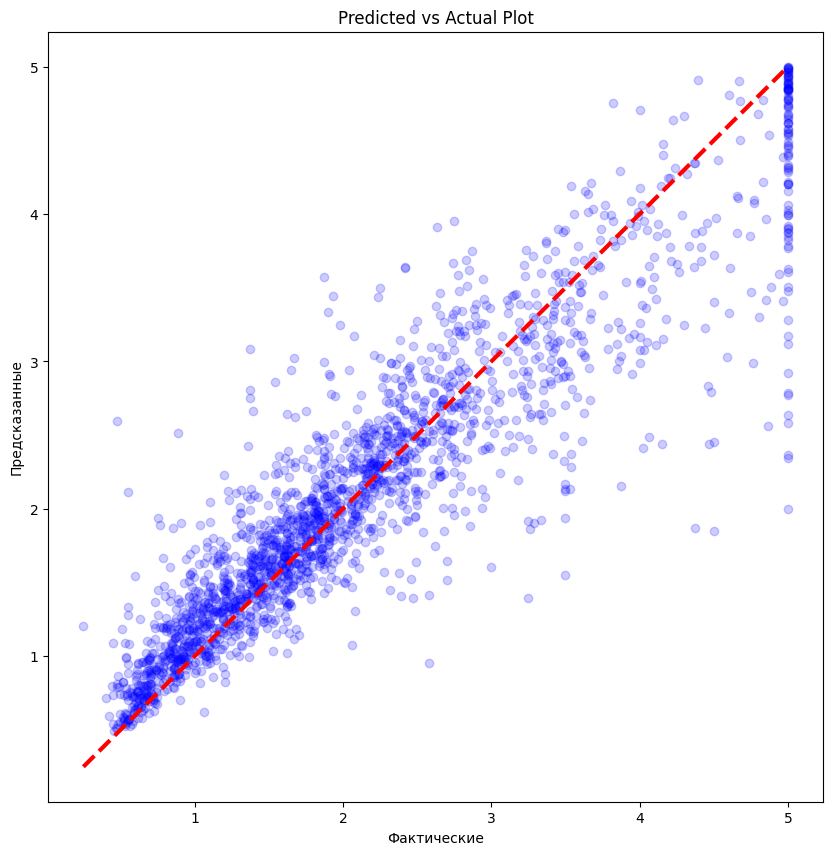

In [52]:
plt.figure(figsize=(10, 10))

plt.scatter(y_test, y_pred, alpha=0.2, color='blue')

max_val = max(np.max(y_test), np.max(y_pred))
min_val = min(np.min(y_test), np.min(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=3)

plt.xlabel('Фактические')
plt.ylabel('Предсказанные')
plt.title('Predicted vs Actual Plot')

plt.show()

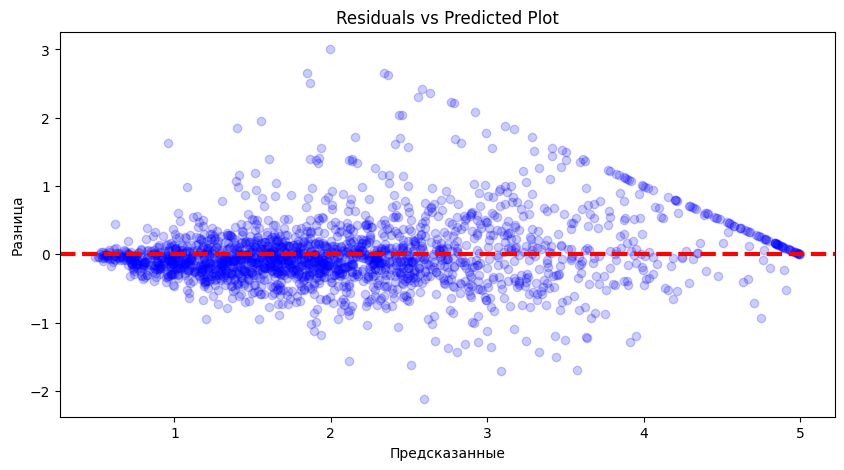

In [53]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 5))

plt.scatter(y_pred, residuals, alpha=0.2, color='blue')
plt.axhline(y=0, color='red', linestyle='--', linewidth=3)

plt.xlabel('Предсказанные')
plt.ylabel('Разница')
plt.title('Residuals vs Predicted Plot')

mean_residual = np.mean(residuals)

plt.show()